Simulating the difference between having treasure hunter or not

In [331]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import ctypes

Setting Up Variables

In [356]:
# {rare, legendary, mythic, unique, common/event}
sell_values = [10,50,200,200,2]

prob = [0.0625,0.0125,0.001,0.001]
prob_th = [1.5*p for p in prob]
prob.append(1-sum(prob))
prob_th.append(1-sum(prob_th))
prob_cc = [0.0625,0.0125,0.001,0.0015]
prob_th_cc = [1.5*p for p in prob_cc]
prob_cc.append(1-sum(prob_cc))
prob_th_cc.append(1-sum(prob_th_cc))
th_cost = 700*7.2577585318
cc_cost = 140*7.2577585318

th_cost

5080.43097226

In [333]:
%%writefile at_sim.c
#include <stdlib.h>
#include <time.h>
#include <math.h>

int draw_index(double *weights, int size) {
    double total = 0.0;
    for (int i = 0; i < size; i++) {
        total += weights[i];
    }

    double r = ((double)rand() / RAND_MAX) * total;
    for (int i = 0; i < size; i++) {
        if (r < weights[i]) {
            return i;
        }
        r -= weights[i];
    }
    return size - 1; // Fallback, though should never happen
}

int breakeven_c(int *nums, double *prob1, double *prob2, int size, double cost) {
    double sum1 = 0.0, sum2 = 0.0;
    int equipment = 0;

    while (fabs(sum1 - sum2) <= cost) {
        int index1 = draw_index(prob1, size);
        int index2 = draw_index(prob2, size);

        sum1 += nums[index1];
        sum2 += nums[index2];
        equipment += 1;
    }

    return equipment * 20;
}

Overwriting at_sim.c


In [334]:
!gcc -shared -o at_sim.so -fPIC at_sim.c

In [ ]:
# Load the shared library
lib = ctypes.CDLL('./at_sim.so')

# Define the argument and return types for the C function
lib.breakeven_c.argtypes = [
    ctypes.POINTER(ctypes.c_int), 
    ctypes.POINTER(ctypes.c_double), 
    ctypes.POINTER(ctypes.c_double), 
    ctypes.c_int, 
    ctypes.c_double
]
lib.breakeven_c.restype = ctypes.c_int

def breakeven(nums, prob1, prob2, cost):
    size = len(nums)
    nums_c = (ctypes.c_int * size)(*nums)
    prob1_c = (ctypes.c_double * size)(*prob1)
    prob2_c = (ctypes.c_double * size)(*prob2)
    
    stages = lib.breakeven_c(nums_c, prob1_c, prob2_c, size, cost)
    return stages


Sample

In [ ]:
info1 = breakeven(sell_values, prob, prob_th, th_cost)
info1

129220

Now for a Simulation

In [337]:
def at_sim(n, nums, prob1, prob2, cost, start):
    stages = np.zeros(n)
    for i in range(n):
        stages[i] = breakeven(nums, prob1, prob2, cost) + start
    return stages

In [ ]:
sims = at_sim(100000, sell_values, prob, prob_th, th_cost, 1000) # Companion Frenzy

133490.0


Text(0, 0.5, 'Frequency')

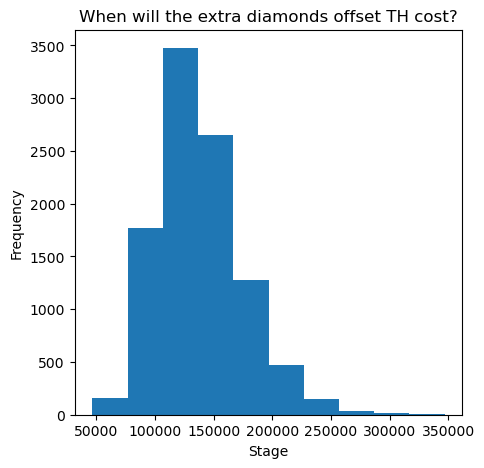

In [349]:
print(np.median(sims))

roundby = lambda n,i: round(n/i)*i
# [s for s in sims if s <= 180000]
plt.figure(figsize=(5,5))
ax1 = plt.hist(sims, bins=10)
plt.title('When will the extra diamonds offset TH cost?')
plt.xlabel('Stage')
plt.ylabel('Frequency')

array([112660., 133490., 158940.])

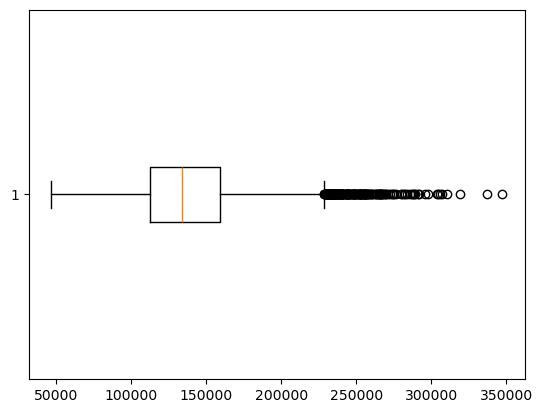

In [350]:
ax2 = plt.boxplot(sims, vert=False)
np.quantile(sims, [0.25,0.5,0.75])